In [1]:
EPOCHS = 200
BATCH_SIZE = 400
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
DATASET_AUGMENTATION_FACTOR = 2

In [2]:
!pip install wandb -qU
import wandb

wandb.login()

wandb: Currently logged in as: ketterko. Use `wandb login --relogin` to force relogin


True

In [3]:
import numpy as np # linear algebra
import pandas as pd
import zipfile
import time
import torch
import torchvision as tv
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import sys
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

%matplotlib inline

DATA_DIR = "./data"

In [4]:
def data_to_numpy(data):
  X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
  X = np.reshape(X,(-1,96, 96))
  Y = data[["left_eye_center_x","left_eye_center_y"]].values.reshape(-1,2).astype('float32')
  return X,Y

def all_data_to_numpy(data):
  X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
  X = np.reshape(X,(-1,96, 96))
  Y = np.delete(data.values,30,axis=1)
  Y = Y.reshape(-1,30).astype('float32')
  return X,Y

def load_data_and_filter_from(file):
  data = pd.read_csv(f'{DATA_DIR}/{file}')
  data = data.dropna()
  return data

def plot_faces(images, coordinates=None, num=5):
  for i in range(num):
    plot_face(images[i],coordinates[i])


def plot_face(image, coordinates=None, num=5):
    plt.imshow(image, interpolation='nearest',cmap="gray")
    if coordinates is not None:
      for i in range(0,len(coordinates)-1,2):
        plt.plot(coordinates[i + 0],coordinates[i + 1],marker=".",color="red")
    plt.show()

def preprocess_images(images, coordinates, transformation):
  transformed_images = []
  for i in range(len(images)):
    img = Image.fromarray(images[i]).convert("RGB")
    img = transformation(img)
    transformed_images.append(np.array(img))

  transformed_coordinates = coordinates * (224/96)
  return transformed_images, transformed_coordinates

def reshape_images_for_resnet(images):
  reshaped_images = np.reshape(images,(-1, 3, 224, 224))
  return reshaped_images

def define_data_loader(images, labels, batch_size, test_data_split, shuffle=True, num_workers=2):
  dataset = list(zip(images,labels))
  dataset_size = len(dataset)
  training_data_size = int(dataset_size*(1-test_data_split))
  train, test = random_split(dataset,[training_data_size, dataset_size - training_data_size])
  trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
  testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
  return trainloader,testloader

def define_single_data_loader(images, labels, batch_size, shuffle=True, num_workers=2):
  return torch.utils.data.DataLoader(list(zip(images, labels)), batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


def plot_predicated_faces(data_loader, num = 10):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.to(device)
  output = net(images)
  coordinates = output.cpu().detach().numpy()
  np_images = images.cpu().detach().numpy()

  plot_faces([i.transpose(1,2,0) for i in np_images], coordinates, num)


In [5]:
import torchvision.transforms.functional as TF
import random

def crop(np_image, coordinates):
    image = np_image.transpose(1,2,0)
    shifted_coordinates = coordinates.copy()
    image_tensor = TF.to_tensor(image)
    MAX_SHIFT = 40
    shiftx = random.randint(-MAX_SHIFT,MAX_SHIFT)
    shifty = random.randint(-MAX_SHIFT,MAX_SHIFT)
    shifted_img = TF.crop(image_tensor, shifty, shiftx, 224, 224)
    
    #random_resize = random.randint(224,400)
    #resized_img = TF.resize(shifted_img, random_resize)


    for i in range(0,len(coordinates)-1,2):
      shifted_coordinates[i + 0] -= shiftx
      shifted_coordinates[i + 1] -= shifty

      #shifted_coordinates[i + 0] *= (random_resize/224)
      #shifted_coordinates[i + 1] *= (random_resize/224)

    
    return shifted_img, shifted_coordinates


def random_pad(np_image, coordinates):
    MAX_PAD = 50

    image_tensor = TF.to_tensor(np_image.transpose(1,2,0))
    copied_coordinates = coordinates.copy()
    
    padding = random.randint(0,MAX_PAD)
    shifted_img = TF.pad(image_tensor, padding)
    
    for i in range(0,len(coordinates)-1,2):
      shifted_coordinates[i + 0] -= shiftx
      shifted_coordinates[i + 1] -= shifty 
    return shifted_img, shifted_coordinates

In [6]:
def plot_predicted_facial_landmarks(*pil_images):
  coordinates = predict_facial_landmarks(*pil_images)
  for i in range(len(pil_images)):
    plot_face(pil_images[0],coordinates[0])

def predict_facial_landmarks(*pil_images):
  preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
  ])

  tensor_images = [preprocess(image) for image in pil_images]
  image_batch = torch.stack(tensor_images,dim=0).to(device)
  net.eval()
  labels = net(image_batch)
  return labels.cpu().detach().numpy()

In [7]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from google.colab import drive
import os
import os.path
import wget

os.chdir("/content")

if not os.path.isfile("./facial-keypoints-detection.zip"):
  url = "https://github.com/ko-redtruck/facial-landmark-detection/raw/main/facial-keypoints-detection.zip"
  wget.download(url, ".")


with zipfile.ZipFile("./facial-keypoints-detection.zip", 'r') as zip_ref:
  zip_ref.extractall("data")

In [10]:
training_data = load_data_and_filter_from('training.zip')
training_data


left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2277          67.180378          35.816373           33.239956   
2278          65.724490          36.301020           25.377551   
2281          68.430866          38.651975           28.895857   
2282          64.152180          30.691592           27.000898   
2283          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170                35.274349   
2              34.909642                59.412000                36.320968   
3              37.261774                60.003339                39.127179   
4              38.042032                58.565890                39.621261   
...                  ...                      ...                      ...   
2277           34.921932                59.347973                37.000904   
2278           37.311224                58.530612                37.739796   
2281           37.617027                61.659350                40.100902   
2282           40.868082                56.505624                34.126963   
2283           38.578939                59.255347                36.065143   

      left_eye_outer_corner_x  left_eye_outer_corner_y  \
0                   73.130346                39.969997   
1                   70.722723                36.187166   
2                   70.984421                36.320968   
3                   72.314713                38.380967   
4                   72.515926                39.884466   
...                       ...                      ...   
2277                72.667896                37.097600   
2278                74.448980                37.525510   
2281                75.586792                40.219182   
2282                73.436776                28.556335   
2283                73.942694                34.624653   

      right_eye_inner_corner_x  right_eye_inner_corner_y  ...  nose_tip_y  \
0                    36.356571                 37.389402  ...   57.066803   
1                    36.034723                 34.361532  ...   55.660936   
2                    37.678105                 36.320968  ...   53.538947   
3                    37.618643                 38.754115  ...   54.166539   
4                    36.982380                 39.094852  ...   64.889521   
...                        ...                       ...  ...         ...   
2277                 39.404349                 36.589944  ...   60.065396   
2278                 33.551020                 38.107143  ...   62.472789   
2281                 37.665118                 39.087245  ...   63.289576   
2282                 34.746122                 40.506939  ...   59.735799   
2283                 37.478531                 39.398041  ...   59.269388   

      mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0               61.195308            79.970165             28.614496   
1               56.421447            76.352000             35.122383   
2               60.822947            73.014316             33.726316   
3               65.598887            72.703722             37.245496   
4               60.671411            77.523239             31.191755   
...                   ...                  ...                   ...   
2277            64.397610            73.248393             35.446431   
2278            66.928121            79.229046             28.015377   
2281  

In [11]:
X_train,Y_train = all_data_to_numpy(training_data)
X_train.shape, Y_train.shape


((2140, 96, 96), (2140, 30))

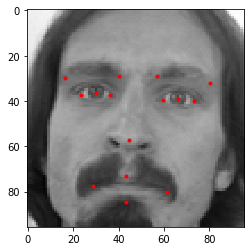

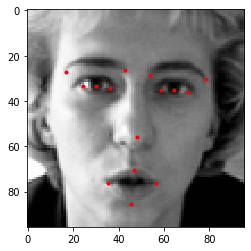

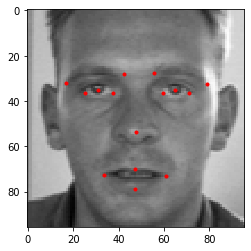

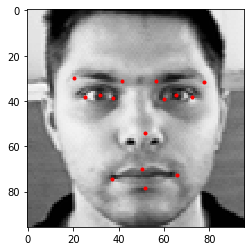

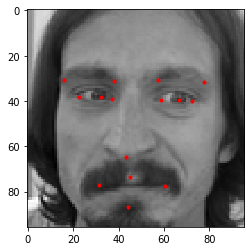

In [12]:
plot_faces(X_train,Y_train)

In [13]:
class AddGaussianNoiseToTensor(object):
    def __init__(self, mean=0.0, std=0.01):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(0.5,0.5,0.5,0.5),
    transforms.RandomAdjustSharpness(5),
    transforms.RandomAdjustSharpness(0.25),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.01,0.02))
])

X2_train, Y2_train = preprocess_images(X_train, Y_train, preprocess)

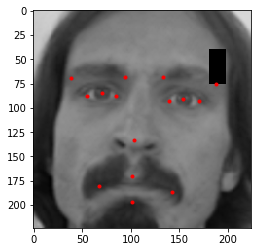

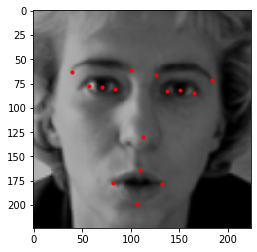

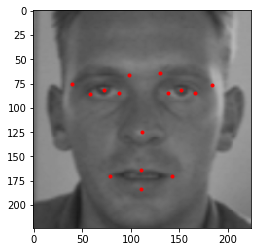

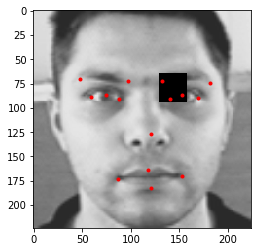

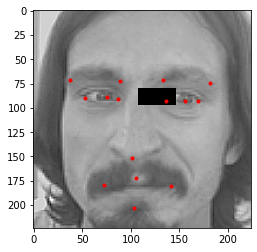

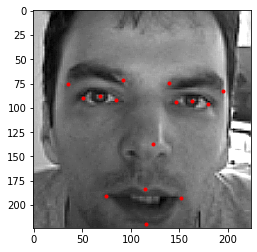

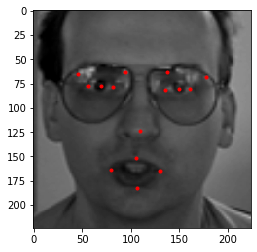

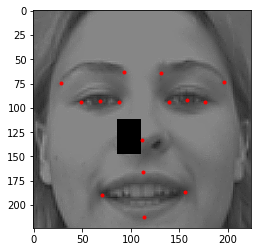

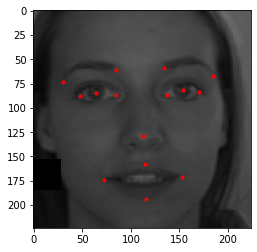

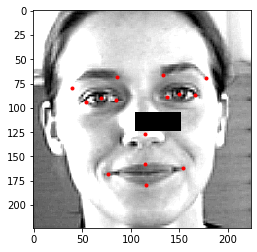

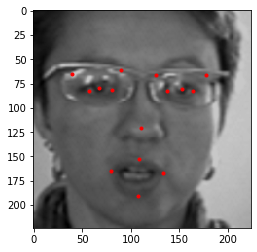

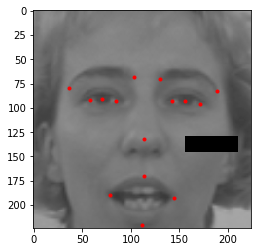

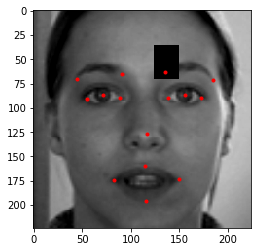

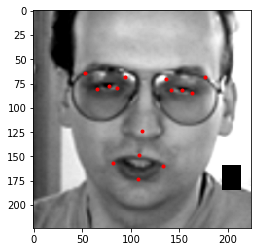

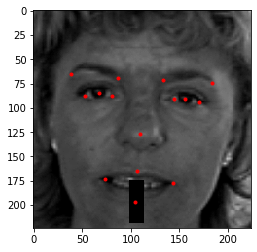

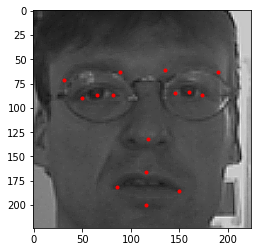

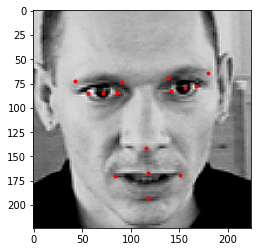

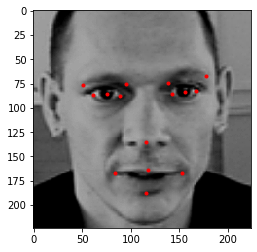

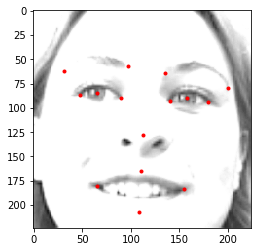

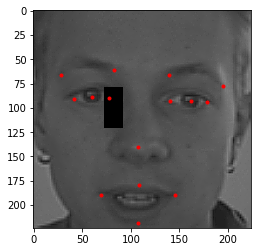

In [14]:
%matplotlib inline
plot_faces([i.transpose(1,2,0) for i in X2_train], Y2_train,20)

In [15]:
X_final_training = reshape_images_for_resnet(X2_train)
X_final_training.shape

(2140, 3, 224, 224)

In [16]:
import torchvision as tv
import torch.nn as nn

net = tv.models.resnet18(pretrained=True)
#net = tv.models.resnet18(weights=None)
net.fc = model = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,30),
        )
net.fc = model

print(net.fc)
#Output final architecture
net.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=30, bias=True)
)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from torch.optim.lr_scheduler import OneCycleLR
#Define Loss
loss_function = nn.MSELoss()

#Define Optimizer(SGD)
optimizer = optim.AdamW(net.parameters())


#worker-cores
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 2


In [18]:
def RMSEPixelLoss(output,labels):
    squared_diff = torch.reshape((output - labels)**2,(-1,15,2))
    distances = torch.sqrt(torch.sum(squared_diff,dim=2))
    summed_distances = torch.sum(distances,dim=1)
    return torch.mean(summed_distances)

#loss_function = RMSEPixelLoss

In [19]:

X_data_augmented = []
Y_data_augmented = []

for k in range(DATASET_AUGMENTATION_FACTOR):
  for i in range(len(X_final_training)):
    img, xy = crop(X_final_training[i],Y2_train[i])

    X_data_augmented.append(img)
    Y_data_augmented.append(xy)

X_data_augmented[0].shape

torch.Size([3, 224, 224])

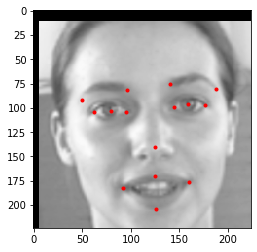

In [20]:
plot_face(TF.to_pil_image(X_data_augmented[20]),Y_data_augmented[20])

In [23]:

trainloader, testloader = define_data_loader(X_data_augmented, Y_data_augmented, BATCH_SIZE, 0.15)

scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=200)



In [24]:
current_epoch = 0
test_image = Image.open('test-photo-konsti.png')
wandb.init(project="facial-landmark-detection", entity="leo-team", config={"net": "ResNet18 + multi layer output", "optimizer": "Adam W", "epochs": EPOCHS, "batch_size": BATCH_SIZE, "lr": LR, "momemtum": MOMENTUM, "weight decay" : WEIGHT_DECAY, "DATASET_AUGMENTATION_FACTOR" : DATASET_AUGMENTATION_FACTOR})

wandb: Currently logged in as: ketterko (leo-team). Use `wandb login --relogin` to force relogin


epoch 1, train loss 14573.166015625, test loss 13549.3203125
epoch 2, train loss 13590.4052734375, test loss 11642.1552734375
epoch 3, train loss 11929.107421875, test loss 9679.1494140625
epoch 4, train loss 9393.32421875, test loss 7854.1357421875
epoch 5, train loss 6275.44677734375, test loss 4825.67578125


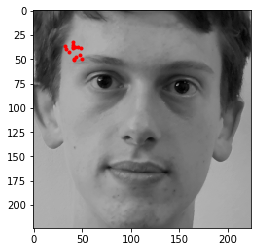

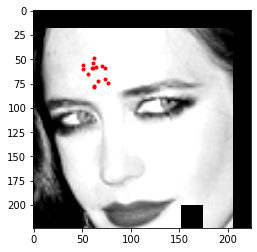

epoch 6, train loss 3152.657958984375, test loss 1646.385986328125
epoch 7, train loss 1335.05224609375, test loss 1348.6536865234375
epoch 8, train loss 852.8038940429688, test loss 582.02978515625
epoch 9, train loss 472.8075256347656, test loss 699.046142578125
epoch 10, train loss 440.4617614746094, test loss 584.3159790039062


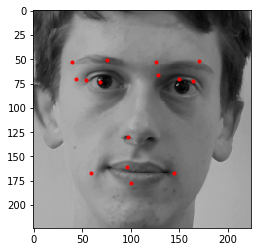

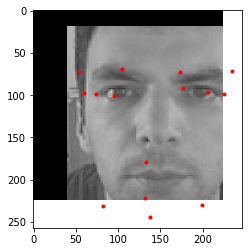

epoch 11, train loss 444.7718200683594, test loss 482.1279602050781
epoch 12, train loss 387.90838623046875, test loss 394.3584899902344
epoch 13, train loss 365.4620361328125, test loss 393.23126220703125
epoch 14, train loss 371.6174011230469, test loss 392.7158508300781
epoch 15, train loss 350.6006774902344, test loss 359.7576599121094


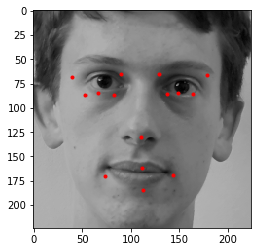

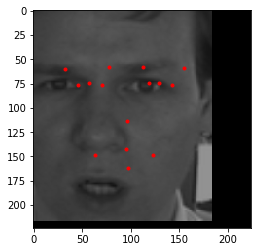

epoch 16, train loss 356.483154296875, test loss 386.93768310546875
epoch 17, train loss 342.11383056640625, test loss 390.84771728515625
epoch 18, train loss 304.92510986328125, test loss 310.0614318847656
epoch 19, train loss 270.8251953125, test loss 272.9306640625
epoch 20, train loss 204.44972229003906, test loss 193.15493774414062


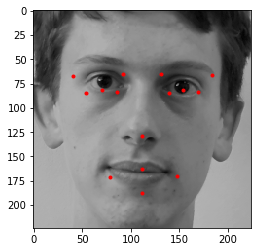

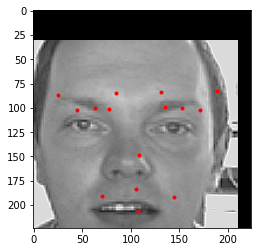

epoch 21, train loss 145.24566650390625, test loss 136.6825408935547
epoch 22, train loss 112.7750015258789, test loss 198.29086303710938
epoch 23, train loss 102.0464859008789, test loss 103.16397857666016
epoch 24, train loss 89.24406433105469, test loss 99.03477478027344
epoch 25, train loss 84.2349853515625, test loss 95.28968048095703


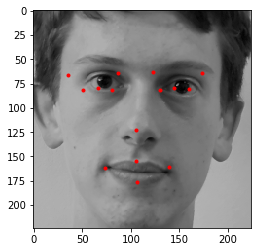

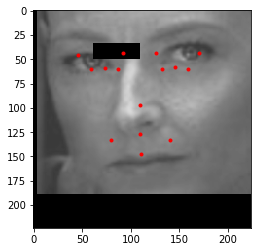

epoch 26, train loss 78.60778045654297, test loss 73.90806579589844
epoch 27, train loss 79.36791229248047, test loss 85.89122009277344
epoch 28, train loss 74.29442596435547, test loss 73.58871459960938
epoch 29, train loss 74.66259765625, test loss 70.84227752685547
epoch 30, train loss 68.09049224853516, test loss 81.96009063720703


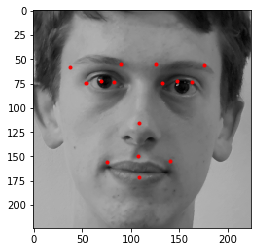

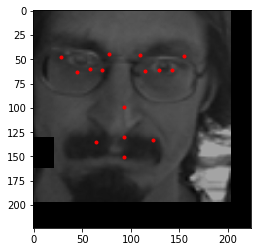

epoch 31, train loss 61.1587028503418, test loss 57.53492736816406
epoch 32, train loss 54.55970001220703, test loss 85.64332580566406
epoch 33, train loss 52.90382766723633, test loss 48.27646255493164
epoch 34, train loss 44.45109176635742, test loss 63.1463623046875
epoch 35, train loss 46.528076171875, test loss 41.28197479248047


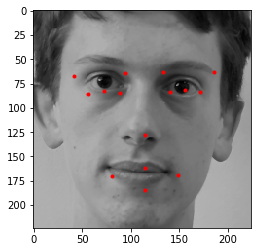

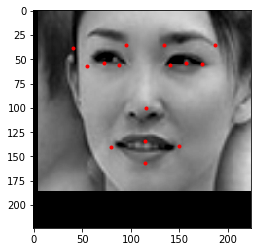

epoch 36, train loss 45.74502182006836, test loss 69.2110824584961
epoch 37, train loss 45.813446044921875, test loss 43.43125915527344
epoch 38, train loss 37.474918365478516, test loss 34.992183685302734
epoch 39, train loss 35.831024169921875, test loss 40.42971420288086
epoch 40, train loss 43.37606430053711, test loss 38.088436126708984


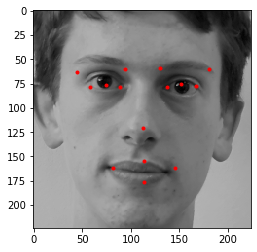

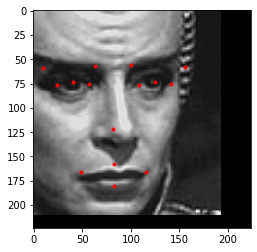

epoch 41, train loss 47.564334869384766, test loss 64.27765655517578
epoch 42, train loss 40.88954162597656, test loss 49.005855560302734
epoch 43, train loss 38.74155044555664, test loss 34.792572021484375
epoch 44, train loss 37.752315521240234, test loss 38.249996185302734
epoch 45, train loss 35.796302795410156, test loss 37.261680603027344


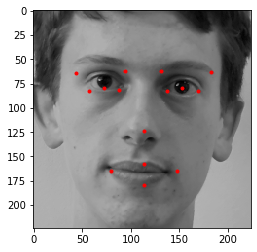

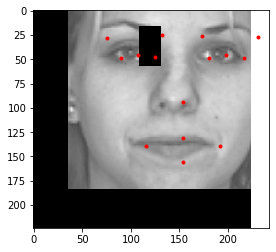

epoch 46, train loss 36.25973129272461, test loss 33.5629997253418
epoch 47, train loss 33.57166290283203, test loss 34.544002532958984
epoch 48, train loss 38.81468963623047, test loss 40.69316864013672
epoch 49, train loss 45.64510726928711, test loss 48.00552749633789
epoch 50, train loss 40.2822265625, test loss 49.9224739074707


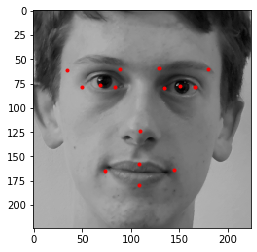

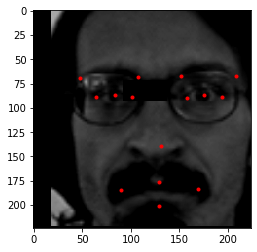

epoch 51, train loss 38.078582763671875, test loss 50.57117462158203
epoch 52, train loss 35.3925666809082, test loss 49.39014434814453
epoch 53, train loss 39.84041976928711, test loss 36.71882247924805
epoch 54, train loss 37.00147247314453, test loss 56.94094467163086
epoch 55, train loss 46.258567810058594, test loss 44.53364944458008


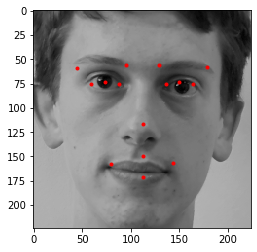

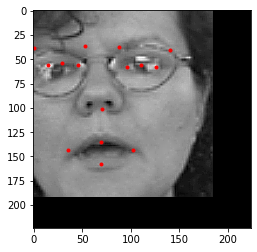

epoch 56, train loss 36.38645553588867, test loss 41.16895294189453
epoch 57, train loss 36.852012634277344, test loss 40.326087951660156
epoch 58, train loss 46.832183837890625, test loss 42.344451904296875
epoch 59, train loss 40.41941452026367, test loss 46.34185028076172
epoch 60, train loss 37.41176986694336, test loss 32.57841491699219


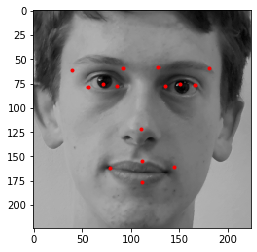

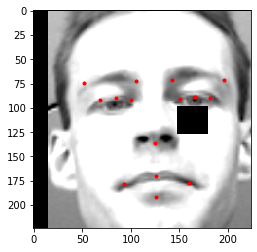

epoch 61, train loss 33.611995697021484, test loss 33.41411590576172
epoch 62, train loss 31.938827514648438, test loss 39.45273971557617
epoch 63, train loss 33.56795883178711, test loss 31.71701431274414
epoch 64, train loss 32.77972412109375, test loss 36.584800720214844
epoch 65, train loss 33.13717269897461, test loss 42.601951599121094


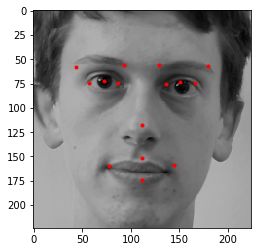

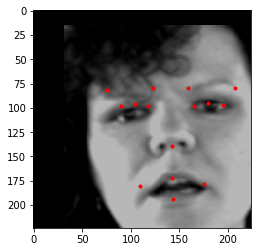

epoch 66, train loss 35.28644561767578, test loss 43.822265625
epoch 67, train loss 39.8359489440918, test loss 33.331321716308594
epoch 68, train loss 41.00759506225586, test loss 58.27177810668945
epoch 69, train loss 52.67890548706055, test loss 87.7411880493164
epoch 70, train loss 42.05106735229492, test loss 41.15022659301758


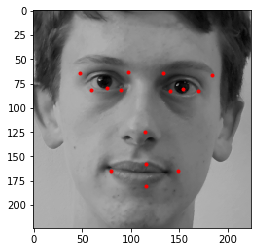

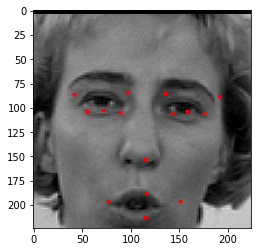

epoch 71, train loss 43.6351203918457, test loss 42.64917755126953
epoch 72, train loss 43.71815872192383, test loss 59.47565460205078
epoch 73, train loss 47.97072982788086, test loss 119.92608642578125
epoch 74, train loss 71.07315826416016, test loss 52.766822814941406
epoch 75, train loss 48.0032958984375, test loss 51.30732727050781


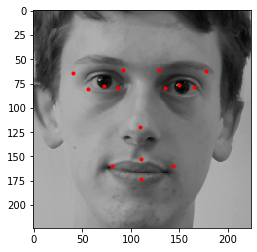

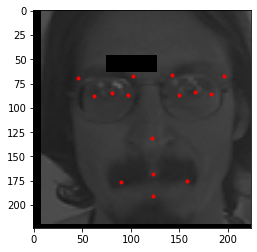

epoch 76, train loss 49.403812408447266, test loss 53.454627990722656
epoch 77, train loss 36.322566986083984, test loss 33.547080993652344
epoch 78, train loss 39.84660339355469, test loss 37.163848876953125
epoch 79, train loss 34.747161865234375, test loss 37.389556884765625
epoch 80, train loss 36.25593185424805, test loss 31.934524536132812


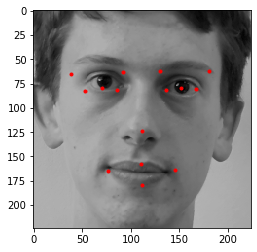

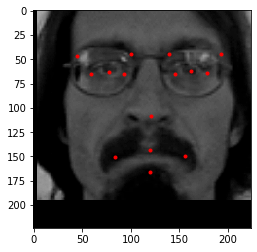

epoch 81, train loss 36.62049102783203, test loss 40.61051940917969
epoch 82, train loss 36.15370559692383, test loss 45.0733528137207
epoch 83, train loss 35.35538864135742, test loss 37.19517517089844
epoch 84, train loss 37.20772933959961, test loss 27.51903533935547
epoch 85, train loss 30.91257667541504, test loss 31.328861236572266


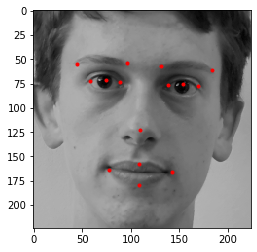

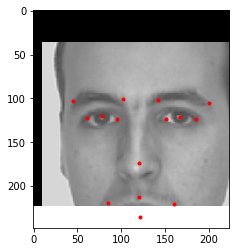

epoch 86, train loss 31.843185424804688, test loss 42.041717529296875
epoch 87, train loss 32.097328186035156, test loss 36.916378021240234
epoch 88, train loss 28.39194107055664, test loss 26.1151123046875
epoch 89, train loss 30.6964168548584, test loss 37.56328201293945
epoch 90, train loss 25.441787719726562, test loss 34.393585205078125


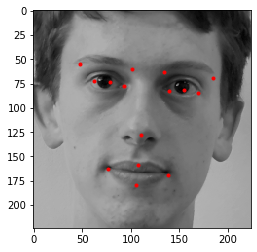

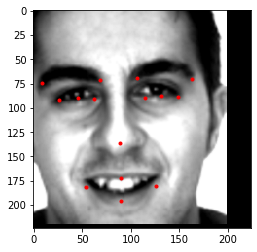

epoch 91, train loss 28.59046745300293, test loss 51.214378356933594
epoch 92, train loss 32.996639251708984, test loss 42.78282928466797
epoch 93, train loss 28.66033935546875, test loss 29.593778610229492
epoch 94, train loss 28.350543975830078, test loss 23.408527374267578
epoch 95, train loss 26.359451293945312, test loss 73.118408203125


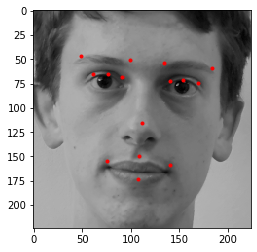

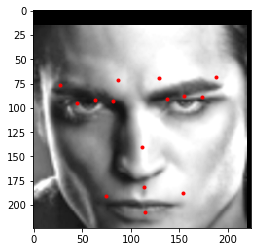

epoch 96, train loss 46.325862884521484, test loss 32.65521240234375
epoch 97, train loss 32.52535629272461, test loss 30.061132431030273
epoch 98, train loss 26.861682891845703, test loss 23.94449234008789
epoch 99, train loss 23.32729148864746, test loss 24.857219696044922
epoch 100, train loss 24.568174362182617, test loss 24.928932189941406


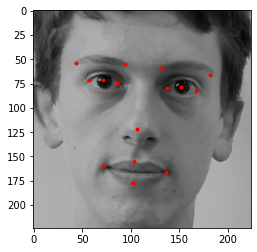

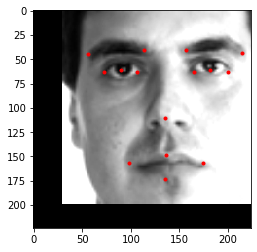

epoch 101, train loss 22.246858596801758, test loss 23.29656219482422
epoch 102, train loss 22.819143295288086, test loss 24.56873321533203
epoch 103, train loss 23.358835220336914, test loss 35.21704864501953
epoch 104, train loss 37.26021957397461, test loss 31.875038146972656
epoch 105, train loss 31.81122398376465, test loss 51.231040954589844


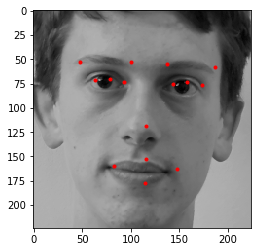

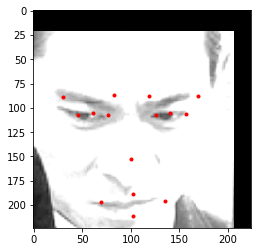

epoch 106, train loss 34.30931091308594, test loss 28.281028747558594
epoch 107, train loss 29.367177963256836, test loss 36.78916931152344
epoch 108, train loss 28.59234046936035, test loss 26.59933853149414
epoch 109, train loss 22.969879150390625, test loss 34.796993255615234
epoch 110, train loss 25.285314559936523, test loss 23.696552276611328


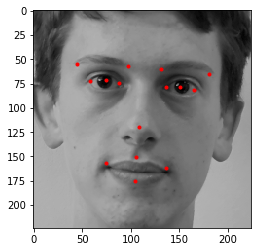

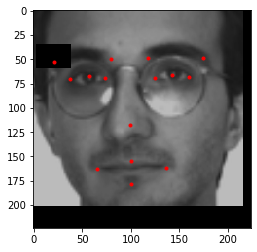

epoch 111, train loss 22.887113571166992, test loss 31.58987808227539
epoch 112, train loss 22.327524185180664, test loss 43.69322967529297
epoch 113, train loss 26.15046501159668, test loss 24.62966537475586
epoch 114, train loss 23.14134407043457, test loss 25.376663208007812
epoch 115, train loss 26.295185089111328, test loss 29.685558319091797


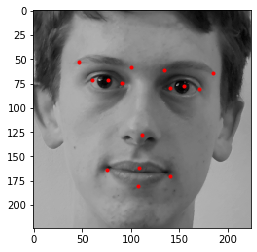

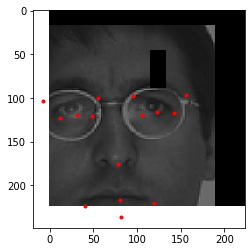

epoch 116, train loss 22.167482376098633, test loss 22.77111053466797
epoch 117, train loss 26.339719772338867, test loss 26.11175537109375
epoch 118, train loss 22.335403442382812, test loss 19.43335723876953
epoch 119, train loss 21.56407928466797, test loss 23.3936767578125
epoch 120, train loss 19.010141372680664, test loss 19.433088302612305


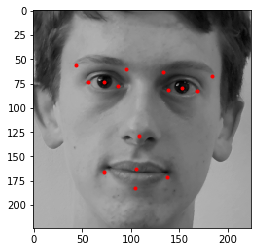

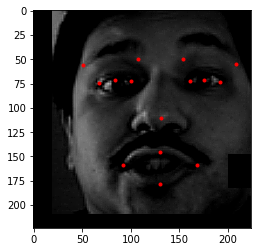

epoch 121, train loss 22.832441329956055, test loss 20.265371322631836
epoch 122, train loss 25.476234436035156, test loss 24.581005096435547
epoch 123, train loss 25.36991310119629, test loss 21.611980438232422
epoch 124, train loss 20.901498794555664, test loss 22.857501983642578
epoch 125, train loss 22.1474552154541, test loss 24.197551727294922


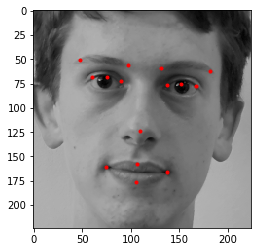

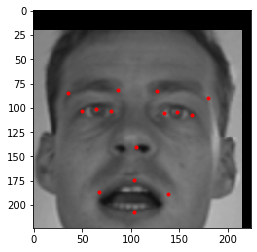

epoch 126, train loss 22.964706420898438, test loss 28.771413803100586
epoch 127, train loss 24.684053421020508, test loss 35.30116653442383
epoch 128, train loss 27.854700088500977, test loss 23.689964294433594
epoch 129, train loss 21.624561309814453, test loss 21.158794403076172
epoch 130, train loss 21.325794219970703, test loss 29.06774139404297


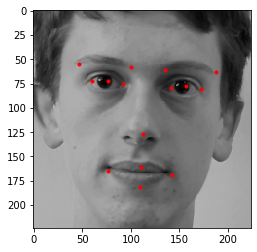

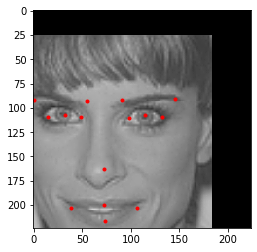

epoch 131, train loss 18.221784591674805, test loss 20.48664093017578
epoch 132, train loss 19.23792839050293, test loss 17.873994827270508
epoch 133, train loss 18.62247085571289, test loss 20.693580627441406
epoch 134, train loss 17.47264862060547, test loss 21.014896392822266
epoch 135, train loss 18.137840270996094, test loss 19.280685424804688


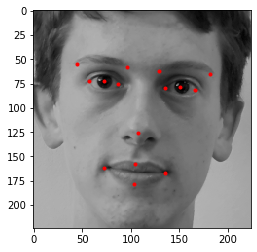

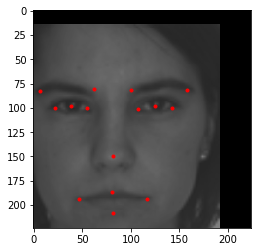

epoch 136, train loss 17.809215545654297, test loss 22.851730346679688
epoch 137, train loss 19.52132225036621, test loss 17.47808837890625
epoch 138, train loss 18.845701217651367, test loss 19.928245544433594
epoch 139, train loss 18.381826400756836, test loss 20.99338150024414
epoch 140, train loss 20.473838806152344, test loss 22.352081298828125


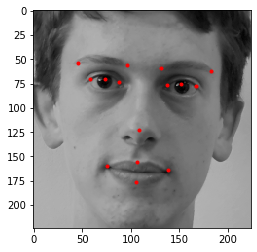

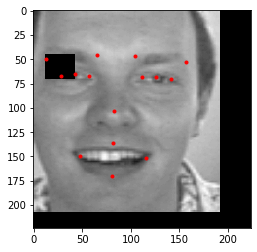

epoch 141, train loss 18.197208404541016, test loss 25.244529724121094
epoch 142, train loss 21.382219314575195, test loss 21.075315475463867
epoch 143, train loss 16.596378326416016, test loss 18.560344696044922
epoch 144, train loss 19.91578483581543, test loss 22.491806030273438
epoch 145, train loss 22.14340591430664, test loss 24.35297393798828


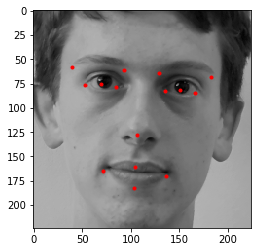

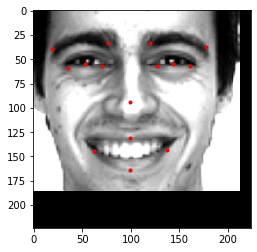

epoch 146, train loss 19.246429443359375, test loss 21.942562103271484
epoch 147, train loss 20.889116287231445, test loss 18.633373260498047
epoch 148, train loss 18.515226364135742, test loss 22.917219161987305
epoch 149, train loss 19.446178436279297, test loss 19.850971221923828
epoch 150, train loss 19.862791061401367, test loss 17.698883056640625


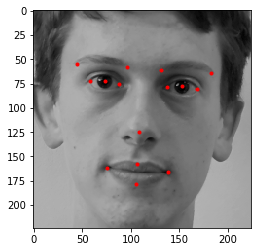

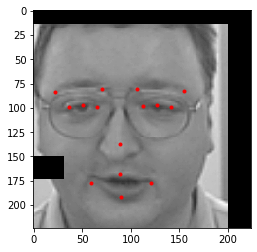

epoch 151, train loss 18.58918571472168, test loss 22.618785858154297
epoch 152, train loss 21.058307647705078, test loss 24.16325569152832
epoch 153, train loss 16.79652976989746, test loss 16.992557525634766
epoch 154, train loss 18.682010650634766, test loss 17.01226043701172
epoch 155, train loss 16.51728057861328, test loss 17.084218978881836


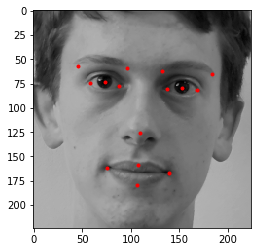

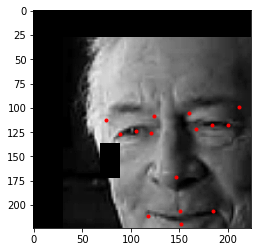

epoch 156, train loss 17.643169403076172, test loss 21.28972625732422
epoch 157, train loss 17.332807540893555, test loss 18.11139488220215
epoch 158, train loss 16.291275024414062, test loss 17.337209701538086
epoch 159, train loss 17.418102264404297, test loss 17.115388870239258
epoch 160, train loss 15.397562980651855, test loss 17.29283905029297


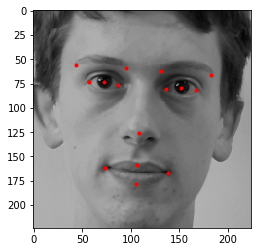

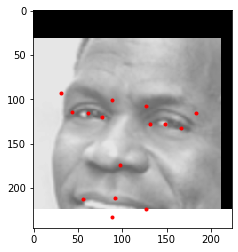

epoch 161, train loss 16.863859176635742, test loss 16.818927764892578
epoch 162, train loss 15.207655906677246, test loss 16.76342010498047
epoch 163, train loss 16.890079498291016, test loss 16.65350341796875
epoch 164, train loss 17.08727264404297, test loss 17.116207122802734
epoch 165, train loss 17.17105484008789, test loss 16.69332504272461


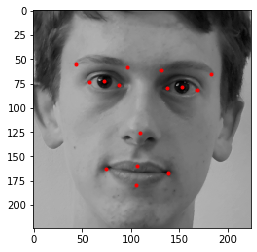

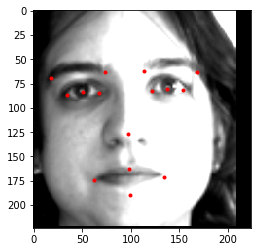

epoch 166, train loss 17.529027938842773, test loss 18.39617919921875
epoch 167, train loss 16.636402130126953, test loss 18.906892776489258
epoch 168, train loss 18.49032974243164, test loss 19.322059631347656
epoch 169, train loss 17.202054977416992, test loss 16.7840576171875
epoch 170, train loss 16.28062629699707, test loss 17.446441650390625


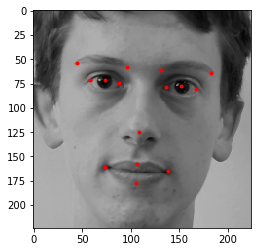

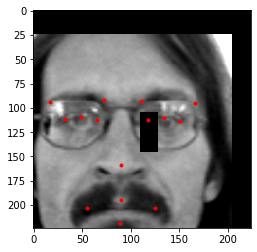

epoch 171, train loss 16.123275756835938, test loss 16.404800415039062
epoch 172, train loss 15.499862670898438, test loss 16.64594078063965
epoch 173, train loss 16.69147300720215, test loss 16.467662811279297
epoch 174, train loss 16.681142807006836, test loss 16.388498306274414
epoch 175, train loss 16.56306266784668, test loss 16.620080947875977


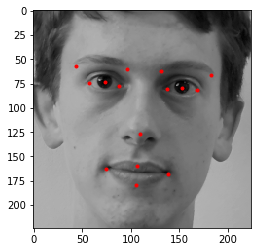

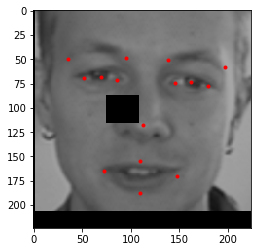

epoch 176, train loss 16.155668258666992, test loss 17.234878540039062
epoch 177, train loss 15.884181022644043, test loss 17.079875946044922
epoch 178, train loss 16.696359634399414, test loss 17.35895347595215
epoch 179, train loss 15.34936809539795, test loss 16.0908203125
epoch 180, train loss 15.736964225769043, test loss 16.412086486816406


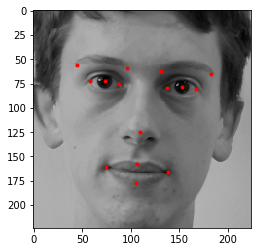

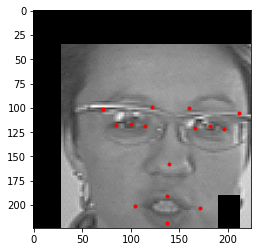

epoch 181, train loss 15.86670207977295, test loss 16.461383819580078
epoch 182, train loss 15.223945617675781, test loss 16.37525749206543
epoch 183, train loss 14.667704582214355, test loss 16.16048240661621
epoch 184, train loss 18.345226287841797, test loss 16.869091033935547
epoch 185, train loss 15.54282283782959, test loss 16.182632446289062


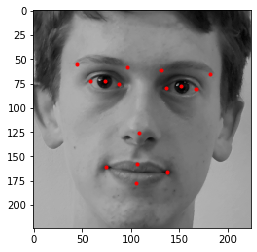

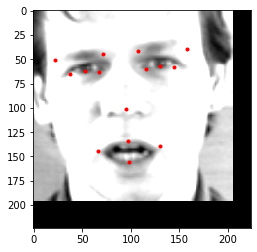

epoch 186, train loss 14.828503608703613, test loss 16.438068389892578
epoch 187, train loss 15.026150703430176, test loss 16.19633674621582
epoch 188, train loss 15.411996841430664, test loss 16.22840118408203
epoch 189, train loss 15.245577812194824, test loss 16.29901885986328
epoch 190, train loss 14.658342361450195, test loss 16.211183547973633


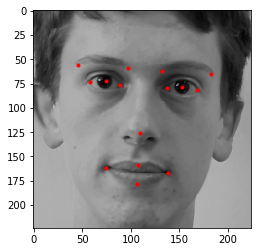

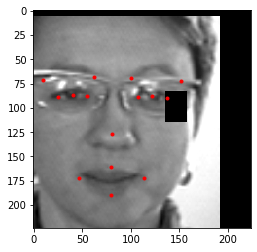

epoch 191, train loss 15.275796890258789, test loss 15.921674728393555
epoch 192, train loss 17.54587745666504, test loss 16.335315704345703
epoch 193, train loss 14.63514232635498, test loss 16.121795654296875
epoch 194, train loss 15.422017097473145, test loss 16.02344512939453
epoch 195, train loss 14.830456733703613, test loss 16.12616729736328


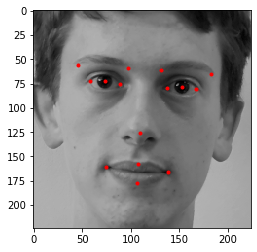

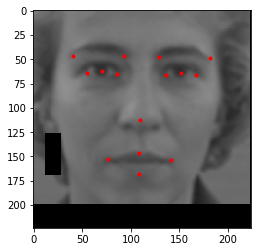

epoch 196, train loss 14.74522590637207, test loss 15.952946662902832
epoch 197, train loss 15.083502769470215, test loss 16.126686096191406
epoch 198, train loss 14.950613975524902, test loss 16.097036361694336
epoch 199, train loss 15.027913093566895, test loss 16.1009464263916
epoch 200, train loss 14.717345237731934, test loss 16.246307373046875


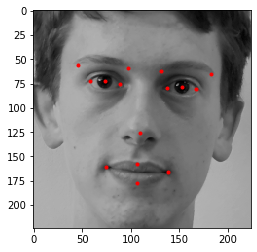

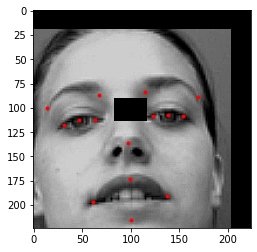

In [25]:

#Move the input and model to GPU for speed if available
net.to(device)

# Specify the number of epochs for training
#Instatiate Logs
running_loss_history = []
running_corrects_history = []

#Train the net
for epoch in range(current_epoch,current_epoch+EPOCHS):  # loop over the dataset multiple times
    current_epoch = epoch
    running_loss = 0.0
    running_corrects = 0.0
    net.train()

    for inputs, labels in trainloader:

        inputs = inputs.to(device) 
        labels = labels.to(device)

        # forward + backward + optimize
        output = net(inputs)
        

        loss = loss_function(output,labels)
        running_loss += loss

        # setting initial parameter gradients to 0
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        #print("loss:",loss.item())
        #running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    epoch_loss = running_loss/len(trainloader) # loss per epoch
    #epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    #running_corrects_history.append(epoch_acc)
    # net.eval()

    net.eval()
    with torch.no_grad():
      test_loss_epoch = 0.0

    
      for X_test, y_test in testloader:
        X_test = X_test.to(device) 
        y_test = y_test.to(device)
      
        b_l = loss_function(net(X_test), y_test) 
        test_loss_epoch += b_l
      test_loss_epoch /= len(testloader)  
    print('epoch {}, train loss {}, test loss {}'.format(epoch+1, epoch_loss, test_loss_epoch))

    if (epoch+1)%5==0:
      plot_predicted_facial_landmarks(test_image)
      plot_predicated_faces(testloader,1)
    
    wandb.log({
      "train_loss": epoch_loss,
      "test_loss": test_loss_epoch,
    })
    

In [ ]:
plot_predicated_faces(testloader,1)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
coordinates = labels.cpu().detach().numpy()
np_images = images.cpu().detach().numpy()


#plot_face(TF.to_pil_image(np_images[0].transpose(1,2,0)),coordinates[0])
img, xy = crop(np_images[0],coordinates[0])
plot_face(TF.to_pil_image(img),xy)


In [ ]:

  
test_image_konsti = Image.open('test-photo-konsti.png')
plot_predicted_facial_landmarks(*[test_image_konsti,test_image_konsti])